# <u> Chargement et nettoyage des données</u>

### Import des modules et librairies


In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report
import sklearn.metrics as sm
from sklearn.model_selection import cross_val_predict

from sklearn.model_selection import GridSearchCV
from sklearn.cluster import KMeans
from sklearn import svm
from sklearn import linear_model
from sklearn.linear_model import ElasticNet

### Load des données et première visualisation

In [2]:
pd.set_option("display.max.columns", None)
df = pd.read_csv("shom_data.csv")

df.head()

,5.1,3.5,1.4,0.2,Whale
0,4.9,3.0,1.4,0.2,Whale
1,4.7,3.2,1.3,0.2,Whale
2,4.6,3.1,1.5,0.2,Whale
3,5.0,3.6,1.4,0.2,Whale
4,5.4,3.9,1.7,0.4,Whale


#### On remarque l'absence de nom des colonnes 
#### On nomme donc les features inconnes : **a, b,c et d** ainsi que l'**espèce**  

In [3]:
df = pd.read_csv("shom_data.csv", header = None, names = ["a", "b", "c", "d", "Species"])


#### On utilise la méthode *describe* pour avoir une idée plus précise du jeu de données

In [4]:
df.describe()

,a,b,c,d
count,153.000000,153.00000,153.000000,153.000000
mean,5.976471,3.04183,3.829412,1.166013
std,2.218960,1.15688,2.325258,0.822477
min,-5.700000,-3.40000,-4.300000,-1.900000
25%,5.100000,2.80000,1.600000,0.300000
50%,5.800000,3.00000,4.400000,1.300000
75%,6.400000,3.30000,5.100000,1.800000
max,23.600000,13.20000,20.800000,2.500000


#### On visualise la distribution des espèces 

array([<AxesSubplot:ylabel='a'>], dtype=object)

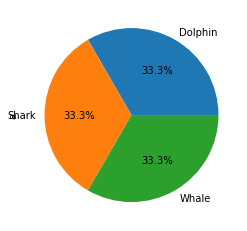

In [5]:
df.groupby(df["Species"])["a"].count().plot(kind='pie', subplots=True, autopct='%1.1f%%')


#### On nettoie les données qui nous semblent suspectent

In [6]:
test = df.loc[(df['a'] < 0) | (df['b'] < 0) | (df['c'] < 0) | (df['d'] < 0)]
test2 = df.loc[(df['a'] > 15) | (df['c'] > 15)]

wanted = pd.concat([test, test2], axis=1)
wanted.head()

,a,b,c,d,Species,a,b,c,d,Species
50,NaN,NaN,NaN,NaN,NaN,20.0,13.2,5.6,1.8,Whale
101,-5.7,-2.5,-4.3,-1.3,Dolphin,NaN,NaN,NaN,NaN,NaN
152,23.6,-3.4,20.8,-1.9,Shark,23.6,-3.4,20.8,-1.9,Shark


In [7]:
df = df.drop([50, 101, 152])
df.describe()

,a,b,c,d
count,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.054000,3.758667,1.198667
std,0.828066,0.433594,1.764420,0.763161
min,4.300000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.800000,3.000000,4.350000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000


# <u> Clustering non supervisé </u>

#### Pour un clustering non-supervisé, on sépare en deux dataframes.
* X : le dataframe des features
* Y : le dataframe des labels

In [8]:
X = df[["c", "d"]]
# X.columns=['a','b','c','d']

y = df["Species"]
# y.columns=['Species']


#### Quand le nombre de clusters réels est inconnu, on peut effectuer ce calcul

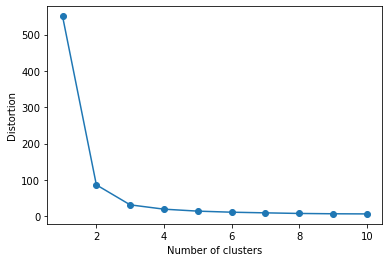

In [9]:
# calculate distortion for a range of number of cluster
distortions = []
for i in range(1, 11):
    km = KMeans(
        n_clusters=i, init='random',
        n_init=10, max_iter=300,
        tol=1e-04, random_state=0
    )
    km.fit(X)
    distortions.append(km.inertia_)

# plot
plt.plot(range(1, 11), distortions, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.show()

#### L'endroit où la coubre se stabilise est une indication du bon nombre de cluster à utiliser
##### (Ici, on pourrait dire 3 ou 6 mais on sait déjà que c'est 3)

#### On crée notre modèle Kmeans puis on le fit à nos données

In [10]:
model = KMeans(
    n_clusters=3, init='random',
    n_init=10, max_iter=300, 
    tol=1e-04, random_state=0
)

y_km = model.fit_predict(X)

print(model.labels_)

[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 0 1 1 1 1
 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1
 1 1]


#### On peut visulaliser ce que ça donne avec des paires de features

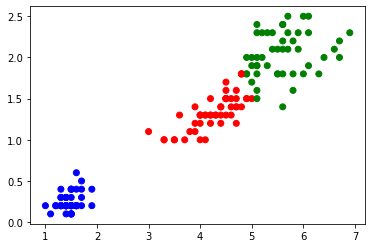

In [11]:
colormap = np.array(['Red', 'green', 'blue'])
plt.scatter(df[["c"]], df[["d"]], c = colormap[model.labels_])

In [12]:
pred = pd.DataFrame(y_km, columns=['predicted'])
result = pd.concat([pred, y], axis=1)

array([<AxesSubplot:ylabel='predicted'>], dtype=object)

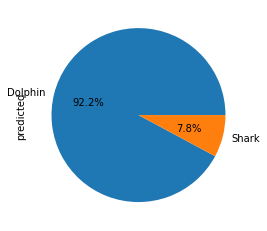

In [13]:
lbl1 = result.loc[result['predicted'] == 0]
lbl1.groupby(df["Species"])["predicted"].count().plot(kind='pie', subplots=True, autopct='%1.1f%%')


array([<AxesSubplot:ylabel='predicted'>], dtype=object)

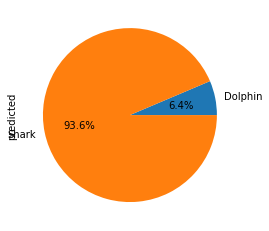

In [14]:
lbl2 = result.loc[result['predicted'] == 1]
lbl2.groupby(df["Species"])["predicted"].count().plot(kind='pie', subplots=True, autopct='%1.1f%%')



array([<AxesSubplot:ylabel='predicted'>], dtype=object)

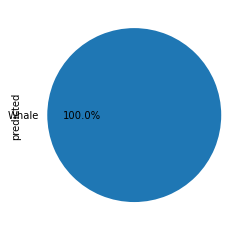

In [15]:
lbl3 = result.loc[result['predicted'] == 2]
lbl3.groupby(df["Species"])["predicted"].count().plot(kind='pie', subplots=True, autopct='%1.1f%%')

# <u> Classification supervisée </u>

### Passage à la classification supervisée avec Linear SVC
* On divise  toujours le dataset en 2 : Features/Label
* Puis on split encore une fois pour avoir une base de train/test 

In [16]:
X = df[["a", "b", "c", "d"]]
y = df["Species"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

#### On **fit** le classifieur avec les données et les labels puis on visualise le score

In [17]:
clf = svm.LinearSVC(max_iter=5000)
clf = clf.fit(X_train, y_train)


result = clf.predict(X_test)


Score : 0.98

               precision    recall  f1-score   support

     Dolphin       0.94      1.00      0.97        15
       Shark       1.00      0.94      0.97        16
       Whale       1.00      1.00      1.00        19

    accuracy                           0.98        50
   macro avg       0.98      0.98      0.98        50
weighted avg       0.98      0.98      0.98        50
 



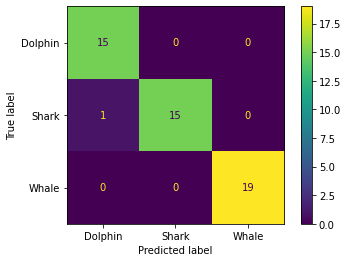

In [18]:
print("Score : " + str(clf.score(X_test, y_test)))
plot_confusion_matrix(clf, X_test, y_test)
print('\n', classification_report(y_test, result), "\n")


# <u> Prédiction de valeur par Regression </u> 

Vu nos données nous allons essayer de prédire des données plausibles pour une certaine espèce

In [19]:
X = df[["a", "b", "c", "d"]]
y = df["Species"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

le = preprocessing.LabelEncoder()
le.fit(y_train)
y_enc_train = le.transform(y_train)
y_enc_test = le.transform(y_test)


In [20]:
class Model:
    def init(self, classifier, parameters, score):
        self.classifier = classifier
        self.parameters = parameters
        self.score = score

    def repr(self):
        return repr((self.classifier, self.parameters, self.score))

classifiers = {
    'lasso': linear_model.Lasso(),
    'elastic': ElasticNet()
}

parameters = {
    'lasso': [
        {'alpha':[0.1, 0.5, 1.0], 'max_iter':[5000, 10000, 20000, 50000], 'tol':[1e-3, 1e-4, 1e-5]}
    ],
    'elastic': [
        {'alpha':[0.1, 0.5, 1.0], 'max_iter':[5000, 10000, 20000, 50000], 'tol':[1e-3, 1e-4, 1e-5]}
    ]
}   
    
results = []
for key, value in classifiers.items():
    gridSearch = GridSearchCV(
        estimator = value,
        param_grid = parameters[key],
        scoring = "accuracy")

    gridSearch.fit(X_train, y_enc_train)

    print(key, gridSearch.bestestimator, gridSearch.bestscore,)
    result = Model(key, gridSearch.bestestimator, gridSearch.bestscore)
    results.append(result)
results = sorted(results, key = lambda result: result.score, reverse = True)



ValueError: Classification metrics can't handle a mix of multiclass and continuous targets

In [ ]:
result = reg.predict(X_test)

In [ ]:
print(result[:5])

In [ ]:
print(y_test[:5])

In [ ]:
print(reg.score(X_test, y_enc_test))
